# ИППИ РАН. Докладчик: Кмито Глеб Леонидович.

* ФПМИ МФТИ, 2 курс (ФИВТ)
* Telegram: [@sasamb4ik](https://t.me/sasamb4ik)
* Почта: kmito.gl@phystech.edu

# Задача 21. Word2Vec

In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install torchinfo

In [64]:
from torchinfo import summary
import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_distances
from collections import Counter, OrderedDict

import torchtext
from torchtext import data, datasets
from torchtext.data.utils import get_tokenizer

import tqdm
from tqdm.keras import TqdmCallback
import tensorflow as tf

In [65]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math

import nltk
nltk.download('stopwords')
nltk.download('punkt')

import string
from string import punctuation
from nltk.corpus import stopwords, udhr
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [75]:
import gensim
from tqdm import tqdm
from collections import Counter

# Сначала начнём делать **предобработку**:


*   Почистим текст от возможных загрязнений с помощью `regex`
*   Отберём слова, основываясь на идее `Frequent Subsampling` из статьи
*   Токенизируем предложения
*   Перед токенизацией выкинем стоп-слова (в том числе пунктуацию), а также предложения длины $\leq$ 3, они вряд ли несут что-то полезное




In [7]:
war_and_peace = open('/content/drive/MyDrive/Colab_Notebooks/WarAndPeace.txt').read().split('\n')

In [8]:
def preprocess(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]
    return tokens

In [9]:
def frequent_subsampling(tokens, threshold=1e-5):
    '''
      Frequent Subsampling идея из статьи Томаса Миколова
    '''
    total_words = len(tokens)
    counts = Counter(tokens)
    subsampled_tokens = []
    for token in tokens:
        freq = counts[token] / total_words
        prob_retain = 1 - math.sqrt(threshold / freq)
        if random.random() < prob_retain:
            subsampled_tokens.append(token)
    return subsampled_tokens

In [10]:
nltk.download('stopwords')
nltk.download('udhr')

vocab = Counter()

for text in war_and_peace:
    vocab.update(preprocess(text))

subsampling_param = 1e-5

total_words = sum(vocab.values())

filtered_vocab = set()

russian_stop_words = set(stopwords.words('russian'))

nltk_punctuation = set([char for lang in udhr.fileids() for char in udhr.raw(lang) if char in string.punctuation])

for word, count in vocab.items():
    if word not in nltk_punctuation:
        if word not in russian_stop_words and len(word) >= 3:
            subsampled_tokens = frequent_subsampling([word]*count, threshold=subsampling_param)
            filtered_vocab.update(subsampled_tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package udhr to /root/nltk_data...
[nltk_data]   Unzipping corpora/udhr.zip.


In [11]:
len(filtered_vocab)

46360

In [12]:
word2id = {}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [13]:
token_sentences = []

for text in war_and_peace:
    tokens = preprocess(text)
    if not tokens:
        continue
    ids = [word2id[token] for token in tokens if token in word2id]
    if len(ids) >= 3:
        token_sentences.append(ids)

In [14]:
len(token_sentences)

10294

# Разобьём на train & test

In [15]:
X = []
y = []

window = 5
for sent in token_sentences:
  for i in range(len(sent)-1):
    word = sent[i] # таргет-слово
    context = sent[max(0, i-window):i] + sent[i+1:i+window]  # контекстные слова
    # в начале и в конце текста окно будет
    # только с одной стороны, но это ничего не сломает
    for context_word in context:
      X.append(word)
      y.append(context_word)

In [16]:
len(X), len(y)

(2176083, 2176083)

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

# Cоздадим **обычную** нейронную сеть с **наивным** SoftMax
### `emb_size = 40`

In [20]:
# инициализируем модель
naive_model = tf.keras.Sequential()

# первым добавляем эмбединг слой, каждому слову (его индексу) сопоставит вектор заданой размерности
naive_model.add(tf.keras.layers.Embedding(input_dim=len(word2id),
                                    input_length=1,
                                    output_dim=40)) # желаемый размер эмбединга

# на выходе из Embedding мы получим массив размерности (1, 100), уберём единичку
naive_model.add(tf.keras.layers.Flatten())

naive_model.add(tf.keras.layers.Dense(len(word2id),
                                activation='softmax'))

# стандартный лосс для классификации - это categorical_crossentropy
# У меня стоит sparse_categorical_crossentropy тк подаем индексы, а по умолчанию нужно подавать
# one-hot векторы или вероятности

# По умолчанию можно ставить adam и менять только learning_rate

naive_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy')

In [21]:
naive_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1, 40)             1854400   
                                                                 
 flatten_1 (Flatten)         (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 46360)             1900760   
                                                                 
Total params: 3755160 (14.32 MB)
Trainable params: 3755160 (14.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
# обучение
# callback = TqdmCallback - параметр, чтобы был виден прогресс обучения
naive_model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=512, # по классике, степень двойки
          epochs=10,
          callbacks=[TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/10
4038/4038 [==============================] - 54s 13ms/step - loss: 9.1562 - val_loss: 9.1023
Epoch 2/10
4038/4038 [==============================] - 52s 13ms/step - loss: 8.9742 - val_loss: 8.9498
Epoch 3/10
4038/4038 [==============================] - 54s 13ms/step - loss: 8.7777 - val_loss: 8.8089
Epoch 4/10
4038/4038 [==============================] - 54s 13ms/step - loss: 8.5758 - val_loss: 8.6906
Epoch 5/10
4038/4038 [==============================] - 51s 13ms/step - loss: 8.3775 - val_loss: 8.5917
Epoch 6/10
4038/4038 [==============================] - 54s 13ms/step - loss: 8.1901 - val_loss: 8.5093
Epoch 7/10
4038/4038 [==============================] - 52s 13ms/step - loss: 8.0191 - val_loss: 8.4425
Epoch 8/10
4038/4038 [==============================] - 53s 13ms/step - loss: 7.8679 - val_loss: 8.3888
Epoch 9/10
4038/4038 [==============================] - 52s 13ms/step - loss: 7.7377 - val_loss: 8.3481
Epoch 10/10
4038/4038 [==============================] - 56s 14m

# Посмотрим на поведение функции потерь в зависимости от числа эпох

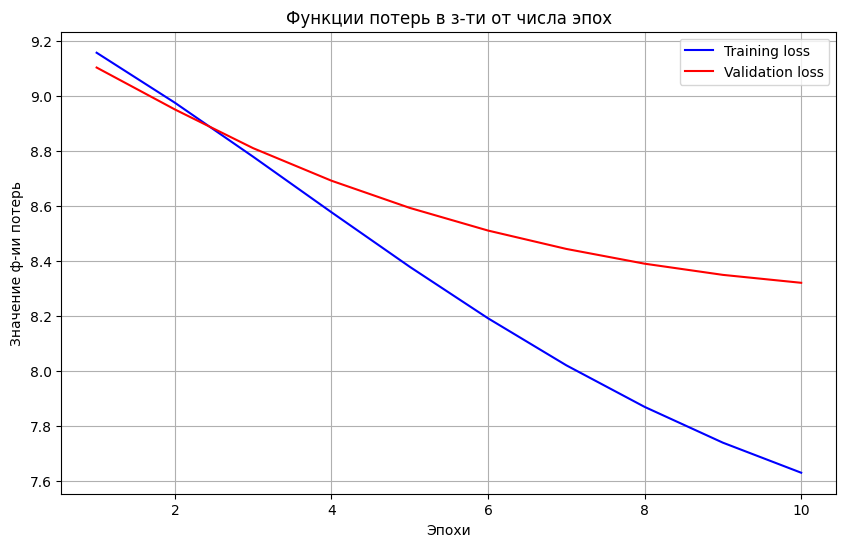

In [24]:
train_loss = naive_model.history.history['loss']
val_loss = naive_model.history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Функции потерь в з-ти от числа эпох')
plt.xlabel('Эпохи')
plt.ylabel('Значение ф-ии потерь')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# я взял 5 эпох, чтобы быстрее обучилось
# ещё увеличим batch_size до 1024
naive_model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1024,
          epochs=5,
          callbacks=[TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/5
2019/2019 [==============================] - 61s 30ms/step - loss: 7.5107 - val_loss: 8.3027
Epoch 2/5
2019/2019 [==============================] - 48s 24ms/step - loss: 7.4601 - val_loss: 8.2929
Epoch 3/5
2019/2019 [==============================] - 46s 23ms/step - loss: 7.4086 - val_loss: 8.2873
Epoch 4/5
2019/2019 [==============================] - 46s 23ms/step - loss: 7.3631 - val_loss: 8.2873
Epoch 5/5
2019/2019 [==============================] - 45s 22ms/step - loss: 7.3245 - val_loss: 8.2921


# Посмотрим теперь на получившиеся векторные представления слов

In [26]:
naive_model.layers

In [27]:
embeddings_1 = naive_model.layers[0].get_weights()[0]
embeddings_2 = naive_model.layers[2].get_weights()[0].T

In [28]:
embeddings = np.mean([embeddings_1, embeddings_2], axis=0)

In [29]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:5]]
    return similar

In [35]:
most_similar("спали", embeddings)

['спали', 'фуражками', 'барышней', 'сенцы', 'выметавшие']

In [36]:
most_similar("турок", embeddings)

['турок', 'пойдет', 'ударить', 'обязано', 'позади']

In [37]:
most_similar("бричка", embeddings)

['бричка', 'овчинный', 'повозке', 'лежавшим', 'отворенную']

In [38]:
most_similar("жеребцом", embeddings)

['жеребцом', 'курским', 'стеблю', 'четвёртая', 'сопловые']

In [39]:
most_similar("пьяному", embeddings)

['пьяному', 'люда', 'воспрещал', 'отпускал', 'негодный']

In [41]:
most_similar("вонючие", embeddings)

['вонючие', 'штаны', 'засунутые', 'полушубок', 'холщовые']

# **Вывод** - в целом, получили неплохой осмысленный результат

*   Для каждого из слов составлены пары, которые имеют смысл
* Предположения для слова **спали**: **спали фуражками вниз, спали с барышней**. Сенцы - это предбанник, возможно кто-то **спал в сенцах**.
* **Бричка** отождествлена с **повозкой**, это идеальное попадание в смыслл
* **Жеребец** действительно может быть **курским**
* Ну и для слов **пьяный** и **вонючие** тоже подобраны слова, которые в паре имеют смысл: **пьяным воспрещено/пьяный люд/вонючие штаны/и т.д.**

# **Negative Sampling**

In [42]:
vocab_size = len(id2word)

In [43]:
def gen_batches_sg(sentences, window = 5, batch_size=1000):

    left_context_length = math.ceil(window / 2)
    right_context_length = window // 2

    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)

                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)

                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [44]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))

embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)

dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

neg_sample_model = tf.keras.Model(inputs=[inputs_target, inputs_context],
                       outputs=outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

neg_sample_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [50]:
len(token_sentences)

10294

In [53]:
# можно варьировать параметр steps_per_epoch, я поставил поменьше, чтобы модель быстрее обучилась
neg_sample_model.fit(gen_batches_sg(token_sentences[:5000], window=5),
          validation_data=gen_batches_sg(token_sentences[5000:],  window=5),
          batch_size=1000,
          steps_per_epoch=3000,
          validation_steps=30,
         epochs=5)

Epoch 1/5
3000/3000 [==============================] - 32s 11ms/step - loss: 0.0815 - accuracy: 0.9786 - val_loss: 0.1829 - val_accuracy: 0.9279
Epoch 2/5
3000/3000 [==============================] - 33s 11ms/step - loss: 0.0599 - accuracy: 0.9841 - val_loss: 0.3728 - val_accuracy: 0.8452
Epoch 3/5
3000/3000 [==============================] - 31s 10ms/step - loss: 0.0474 - accuracy: 0.9875 - val_loss: 0.6296 - val_accuracy: 0.7892
Epoch 4/5
3000/3000 [==============================] - 34s 11ms/step - loss: 0.0398 - accuracy: 0.9896 - val_loss: 0.8146 - val_accuracy: 0.7595
Epoch 5/5
3000/3000 [==============================] - 33s 11ms/step - loss: 0.0343 - accuracy: 0.9910 - val_loss: 0.9231 - val_accuracy: 0.7453


In [54]:
neg_sample_model.layers

In [55]:
embeddings = neg_sample_model.layers[2].get_weights()[0]

In [56]:
most_similar("спали", embeddings)

['спали', 'десятого', 'лучинки', 'заезжие', 'ослепни']

In [57]:
most_similar("турок", embeddings)

['турок', 'разделяло', 'заунывные', 'пододвинет', 'примется']

In [58]:
most_similar("бричка", embeddings)

['бричка', 'развязной', 'традиционной', 'подскочил', 'нарева']

In [59]:
most_similar("жеребцом", embeddings)

['жеребцом', 'стеблю', 'курским', 'четвёртая', 'начатым']

In [60]:
most_similar("пьяному", embeddings)

['пьяному', 'истребляйть', 'повернуться', 'уезжают', 'люда']

In [61]:
most_similar("вонючие", embeddings)

['вонючие', 'саквояжи', 'глазастей', 'выпушки', 'полураскрытые']

In [62]:
most_similar("офицеры", embeddings)

['офицеры', 'сборных', 'благочестивыми', 'подбрасывали', 'доработках']

# **Вывод** - получили ускорение обучения (вне зависимости от маленького steps_per_epoch, все равно работает быстрее)

* Заметим, что на некоторых словах имеем повторяющиеся результаты - значит, в этих парах можем быть точно уверены
* Снова получаем осознанные результаты

# Теперь откроем для себя библиотеку **Gensim**

## Сравним **Neg Sampling**, **Hierarchical Softmax**, **обычный Gensim**



*   Параметр `sg=1` отвечает за выбор `Skip-Gram`, а не `CBOW`
*   Параметры `hs=1` и `negative=1` отвечают за выбор иерархического SoftMax и Negative Sampling соответственно



In [69]:
texts = [preprocess(text) for text in war_and_peace if len(preprocess(text)) > 3]

In [71]:
len(texts)

10431

In [85]:
texts[0]

['л', 'н', 'достоевский', '«кампания', 'и', 'континент»']

### Пробуем `Negative Sampling` с 7 сэмплами

In [83]:
%%time
base_word2vec = gensim.models.Word2Vec(texts, min_count=1,sg=1,hs=0,negative=7)

CPU times: user 28.1 s, sys: 103 ms, total: 28.2 s
Wall time: 17.7 s


In [93]:
words_to_analyze = ['офицеры', 'турок', 'зависть', 'бричка', 'государь']

In [94]:
def analyse_results(words_to_analyze, model_type):
  most_similar_words = {}

  for word in tqdm(words_to_analyze):
    try:
      similar_words = model_type.wv.most_similar(word, topn=5)
      most_similar_words[word] = similar_words
    except KeyError:
        print(f"Слово '{word}' не находится в словаре.")

  for word, similar_words in most_similar_words.items():
    print(f"Слово: {word}")
    print()
    for similar_word, similarity_score in similar_words:
        print(f"Похожее слово: {similar_word}, Вероятность: {similarity_score}")
    print()


In [96]:
analyse_results(words_to_analyze, base_word2vec)

100%|██████████| 5/5 [00:00<00:00, 184.75it/s]

Слово: офицеры

Похожее слово: унтер-офицеры, Вероятность: 0.9307476282119751
Похожее слово: бежали, Вероятность: 0.9217262268066406
Похожее слово: английские, Вероятность: 0.9179248809814453
Похожее слово: пошли, Вероятность: 0.9130265116691589
Похожее слово: некоторые, Вероятность: 0.8983425498008728

Слово: турок

Похожее слово: оказываться, Вероятность: 0.9600985050201416
Похожее слово: осталось, Вероятность: 0.9578699469566345
Похожее слово: левый, Вероятность: 0.9576862454414368
Похожее слово: останется, Вероятность: 0.9573100209236145
Похожее слово: бородинское, Вероятность: 0.9570885300636292

Слово: зависть

Похожее слово: коль, Вероятность: 0.9870361685752869
Похожее слово: простил, Вероятность: 0.9865924715995789
Похожее слово: почему-либо, Вероятность: 0.9846252799034119
Похожее слово: ужасна, Вероятность: 0.9842065572738647
Похожее слово: юность, Вероятность: 0.9839932322502136

Слово: бричка

Похожее слово: варкой, Вероятность: 0.9930304288864136
Похожее слово: донской, В

# Получаем очень хорошие и осмысленные резуольтаты, в частности:

*   С **офицерами** идеальное попадание в смысл
*   На слово **государь** модель выдаёт имена людей, что является осмысленным и логичным.



# Теперь попробуем **Hierarchical Softmax**

In [89]:
%%time
hierarch_word2vec = gensim.models.Word2Vec(texts, min_count=1,sg=1,hs=1,negative=0)

CPU times: user 22.6 s, sys: 110 ms, total: 22.7 s
Wall time: 1min 7s


In [98]:
analyse_results(words_to_analyze, hierarch_word2vec)

100%|██████████| 5/5 [00:00<00:00, 86.47it/s]

Слово: офицеры

Похожее слово: унтер-офицеры, Вероятность: 0.7064436078071594
Похожее слово: кавалерийские, Вероятность: 0.6826833486557007
Похожее слово: уланы, Вероятность: 0.6819370985031128
Похожее слово: английские, Вероятность: 0.6816344261169434
Похожее слово: бежали, Вероятность: 0.6710196137428284

Слово: турок

Похожее слово: отбит, Вероятность: 0.5980252623558044
Похожее слово: передвигаются, Вероятность: 0.5963581204414368
Похожее слово: истреблена, Вероятность: 0.572993278503418
Похожее слово: задержан, Вероятность: 0.5692239999771118
Похожее слово: пансионы, Вероятность: 0.5690258741378784

Слово: зависть

Похожее слово: получаю, Вероятность: 0.6974465250968933
Похожее слово: позволит, Вероятность: 0.6837061643600464
Похожее слово: раскаивается, Вероятность: 0.6794800758361816
Похожее слово: забуду, Вероятность: 0.6742539405822754
Похожее слово: ловит, Вероятность: 0.6704015135765076

Слово: бричка

Похожее слово: овчинный, Вероятность: 0.8407329320907593
Похожее слово: л

# Видим, что тут он без подбора параметров справляется хуже, чем Negative Sampling. Попробуем хотя бы 1 раз подобрать параметры, чтобы улучшить результат.

Есть еще несколько параметров:

* **sample** - отвечает за downsampling частотных слов; чем меньше, тем сильнее штрафуются частотные слова (по умолчанию стоит 1e-3, но можно поставить 1e-4, 1e-5). Для sg это будет значительно влиять на скорость (1e-5 будет быстрее)  
* **ns_exponent** -  регулирет downsampling частотных слов в negative sampling; 0 - никакого штрафа за частотность (как у нас выше с полным рандомом), 1 - штрафует пропорционально частотности, значения 0-1 что-то посередине (по умолчанию 0.75)  

In [101]:
%%time
hierarch_word2vec_update = gensim.models.Word2Vec(texts, min_count=1,sg=1,hs=1,negative=0,sample=1e-5)

CPU times: user 12.6 s, sys: 130 ms, total: 12.7 s
Wall time: 9.15 s


In [102]:
analyse_results(words_to_analyze, hierarch_word2vec_update)

100%|██████████| 5/5 [00:00<00:00, 231.96it/s]

Слово: офицеры

Похожее слово: утренними, Вероятность: 0.8829641342163086
Похожее слово: встолченной, Вероятность: 0.8829205632209778
Похожее слово: неуверены, Вероятность: 0.8819947838783264
Похожее слово: вычищен, Вероятность: 0.878150463104248
Похожее слово: предстаём, Вероятность: 0.8778148889541626

Слово: турок

Похожее слово: херувимов, Вероятность: 0.8448445200920105
Похожее слово: моисею, Вероятность: 0.837394118309021
Похожее слово: ein, Вероятность: 0.8356873393058777
Похожее слово: вывезен, Вероятность: 0.835387647151947
Похожее слово: перекрестил, Вероятность: 0.8342860341072083

Слово: зависть

Похожее слово: сочинения, Вероятность: 0.8522939085960388
Похожее слово: соединявшееся, Вероятность: 0.8500381708145142
Похожее слово: кем-нибудь, Вероятность: 0.84159916639328
Похожее слово: сменялось, Вероятность: 0.8336148262023926
Похожее слово: неурожаю, Вероятность: 0.833137571811676

Слово: бричка

Похожее слово: спуталось, Вероятность: 0.9036630392074585
Похожее слово: пром

### **Выводы**:

* Получили более стабильные результаты для Hierarchical Softmax, но Negative Sampling всё ещё лучше
* Узнали про чудо-библиотеку `Gensim`
* По итогу, **Negative Sampling** оказался лучшим из подходов.